# Main character analysis
22 November 2024

This notebook demonstrates that when looking at who talks about who in the General Assembly, the distribution of mentions is  highly asymmetric. 

There are three figures: 
`Figure 1`:  
`Figure 2`: 
`Figure 3`: 

# Load and prepare data

In [1]:
import pandas as pd
import json

ungdc = pd.read_csv("C:/Users/spatt/Desktop/diss_3/prodigy_custom/data/processed/ungdc_model-v5_EntityContext_02.csv")

# Rename columns to "source" and "target"
ungdc.rename(columns={
    'iso': 'source',
    'ISO_Code': 'target'
}, inplace=True)


# Create the 'self' dummy variable
ungdc['self'] = (ungdc['source'] == ungdc['target']).astype(int)

In [ ]:
# FIGURE 1: distribution of mentions for the full dataset 

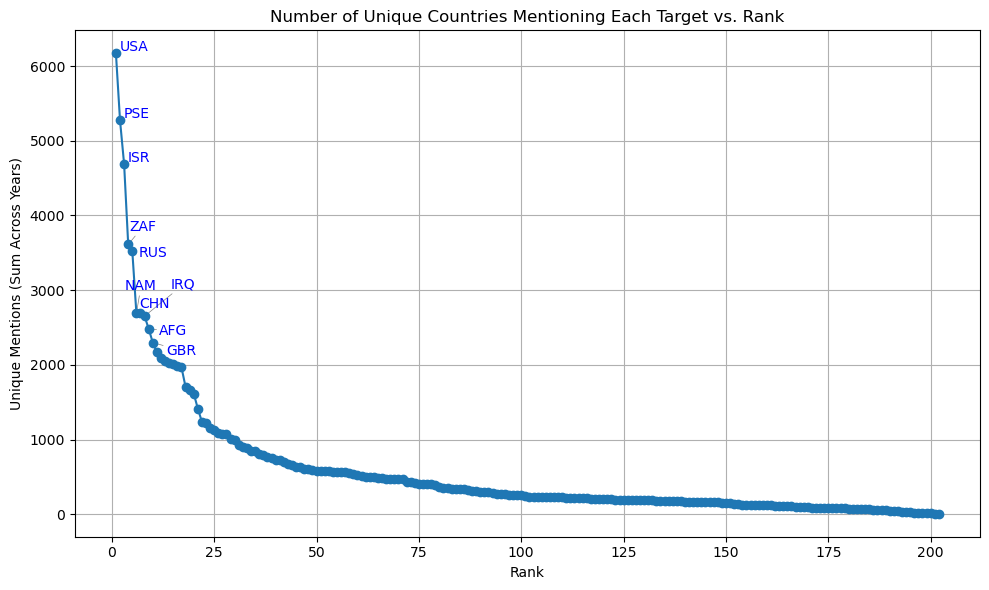

In [2]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Step 1: Drop self-mentions
ungdc_no_self = ungdc[ungdc['self'] == 0]

# Step 2: Calculate unique countries mentioning each target per year
yearly_unique_mentions = (
    ungdc_no_self.groupby(['target', 'year'])['source']
    .nunique()
    .reset_index(name='unique_countries_per_year')
)

# Step 3: Sum unique mentions across all years for each target
total_unique_mentions = (
    yearly_unique_mentions.groupby('target')['unique_countries_per_year']
    .sum()
    .sort_values(ascending=False)
)

# Step 4: Prepare data for plotting
ranks = range(1, len(total_unique_mentions) + 1)
values = total_unique_mentions.values
labels = total_unique_mentions.index[:10]  # Top 10 targets for labeling

# Step 5: Plot Frequency vs. Rank
plt.figure(figsize=(10, 6))
plt.plot(ranks, values, marker='o', linestyle='-')
plt.title('Number of Unique Countries Mentioning Each Target vs. Rank')
plt.xlabel('Rank')
plt.ylabel('Unique Mentions (Sum Across Years)')
plt.grid(True)

# Add labels for top 10 targets
texts = []
for i in range(10):
    texts.append(plt.text(ranks[i], values[i], labels[i], fontsize=10, color='blue'))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
plt.tight_layout()
plt.show()


# FIGURE 2: GINI PLOT

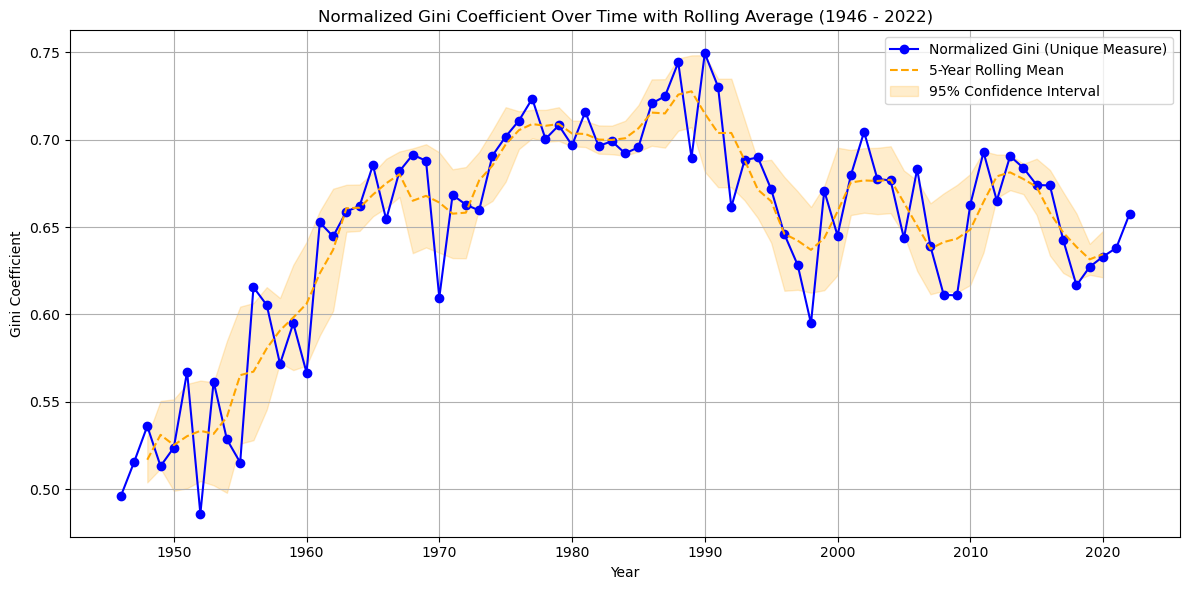

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute unique mentions per target per year
yearly_unique_mentions = (
    ungdc_no_self.groupby(['year', 'target'])['source']
    .nunique()
    .reset_index(name='unique_countries_per_year')
)

# Step 2: Group unique mentions by year
yearly_totals = yearly_unique_mentions.groupby('year')['unique_countries_per_year'].apply(list)

# Step 3: Count the number of unique states (actors) per year
actors_per_year = ungdc_no_self.groupby('year')['source'].nunique()

# Step 4: Normalize unique mentions by the number of actors per year
normalized_yearly_totals = {
    year: [count / actors_per_year[year] for count in values]
    for year, values in yearly_totals.items()
}

# Step 5: Define a function to calculate Gini coefficient
def gini_coefficient(values):
    values = np.array(values)
    values_sorted = np.sort(values)
    n = len(values)
    cumulative_sum = np.cumsum(values_sorted)
    gini = (n + 1 - 2 * np.sum(cumulative_sum) / cumulative_sum[-1]) / n
    return gini

# Step 6: Compute Gini coefficient for normalized values
normalized_gini_per_year = {year: gini_coefficient(values) for year, values in normalized_yearly_totals.items()}

# Convert Gini coefficients to a pandas DataFrame for rolling calculations
gini_df = pd.DataFrame(list(normalized_gini_per_year.items()), columns=['Year', 'Gini']).sort_values('Year')
gini_df.set_index('Year', inplace=True)

# Step 7: Calculate rolling mean and confidence interval
window = 5
gini_df['Rolling Mean'] = gini_df['Gini'].rolling(window=window, center=True).mean()
gini_df['Rolling Std'] = gini_df['Gini'].rolling(window=window, center=True).std()
gini_df['Lower CI'] = gini_df['Rolling Mean'] - 1.96 * gini_df['Rolling Std'] / np.sqrt(window)
gini_df['Upper CI'] = gini_df['Rolling Mean'] + 1.96 * gini_df['Rolling Std'] / np.sqrt(window)

# Step 8: Plot Gini coefficients with rolling average and confidence interval
plt.figure(figsize=(12, 6))
plt.plot(gini_df.index, gini_df['Gini'], marker='o', linestyle='-', label='Normalized Gini (Unique Measure)', color='blue')
plt.plot(gini_df.index, gini_df['Rolling Mean'], linestyle='--', label='5-Year Rolling Mean', color='orange')
plt.fill_between(gini_df.index, gini_df['Lower CI'], gini_df['Upper CI'], color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('Normalized Gini Coefficient Over Time with Rolling Average (1946 - 2022)')
plt.xlabel('Year')
plt.ylabel('Gini Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FIGURE 3 - Main Characters

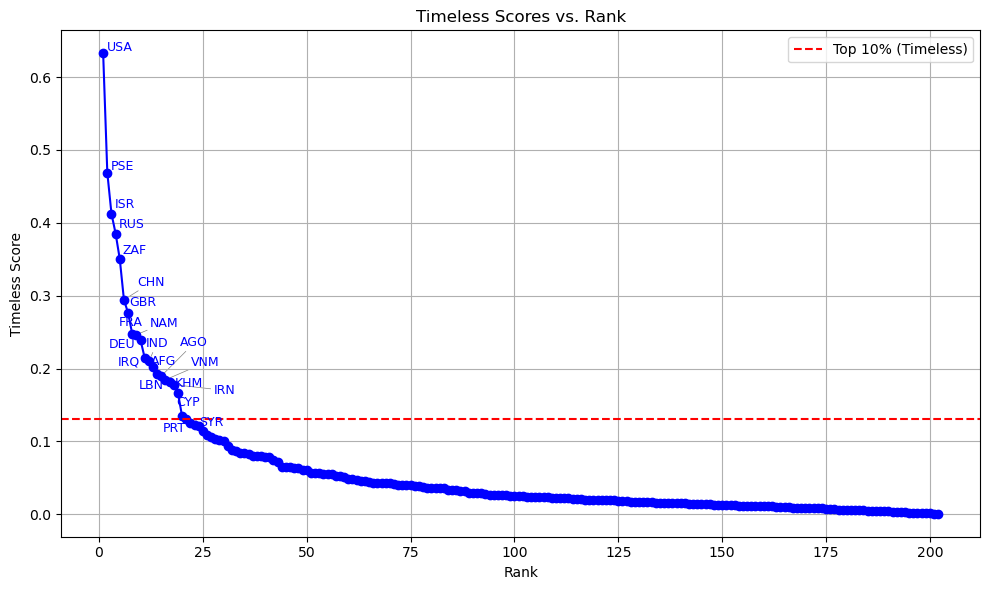

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Step 1: Compute unique mentions per target per year
yearly_unique_mentions = (
    ungdc_no_self.groupby(['year', 'target'])['source']
    .nunique()
    .reset_index(name='unique_mentions')
)

# Step 2: Calculate total number of years each target is mentioned
years_mentioned = yearly_unique_mentions.groupby('target')['year'].nunique()

# Step 3: Calculate total unique mentions for each target
total_unique_mentions = yearly_unique_mentions.groupby('target')['unique_mentions'].sum()

# Step 4: Normalize yearly mentions by the number of states in each year
actors_per_year = ungdc_no_self.groupby('year')['source'].nunique()
yearly_unique_mentions['normalized_mentions'] = yearly_unique_mentions.apply(
    lambda row: row['unique_mentions'] / actors_per_year[row['year']], axis=1
)

# Step 5: Compute average normalized mentions per year
avg_normalized_mentions = (
    yearly_unique_mentions.groupby('target')['normalized_mentions'].mean()
)

# Step 6: Compute proportion of years mentioned
total_years = yearly_unique_mentions['year'].nunique()
proportion_years_mentioned = years_mentioned / total_years

# Step 7: Calculate "timeless" score
timeless_score = proportion_years_mentioned * avg_normalized_mentions

# Combine into a single DataFrame
timeless_df = pd.DataFrame({
    'total_unique_mentions': total_unique_mentions,
    'proportion_years_mentioned': proportion_years_mentioned,
    'avg_normalized_mentions': avg_normalized_mentions,
    'timeless_score': timeless_score
}).sort_values(by='timeless_score', ascending=False)

# Step 8: Sort timeless scores by rank
timeless_scores_sorted = timeless_df.sort_values('timeless_score', ascending=False).reset_index()

# Step 9: Assign ranks
ranks = range(1, len(timeless_scores_sorted) + 1)

# Step 10: Plot timeless score vs. rank
plt.figure(figsize=(10, 6))
plt.plot(ranks, timeless_scores_sorted['timeless_score'], marker='o', linestyle='-', color='blue')
plt.title('Timeless Scores vs. Rank')
plt.xlabel('Rank')
plt.ylabel('Timeless Score')
plt.grid(True)

# Add horizontal line for the top 10% cutoff
cutoff_value = timeless_scores_sorted['timeless_score'].quantile(0.90)
plt.axhline(y=cutoff_value, color='red', linestyle='--', label='Top 10% (Timeless)')

# Add labels for the top 10% (highest ranks)
top_10_percent = timeless_scores_sorted[timeless_scores_sorted['timeless_score'] >= cutoff_value]
texts = []
for i, row in top_10_percent.iterrows():
    state_label = row['target']  # Use 'target' for state names
    texts.append(plt.text(ranks[row.name], row['timeless_score'], state_label, fontsize=9, color='blue'))

# Adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Add legend
plt.legend()

plt.tight_layout()
plt.show()
